In [677]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Implementation of optimizers for minmax problem

We define the loss function $L(x,y) = x^TAy$, together with $F(x,y) = [\nabla L_x, -\nabla L_y]$ and want to solve the problem $min_xmax_yL(x,y)$

Define $z = [x,y]$ where $x, y \in \mathbb{R}^n$, so that $z \in \mathbb{R}^{2n}$ and $A \in \mathbb{R}^{n\times n}$

In [678]:
# 2d
z0 = np.array([[.5,.5],[-2.0,-1.0]])
# A = np.array([[1,0],[0,1]]) # Identity, cool case
# A = np.array([[0.5,3],[-1,-2]]) # completely unstable
# A = np.array([[0.5,3],[-1,0]])  # only EGM converges but following a vey chaotic trajectory
# A = np.array([[3,2],[-1,1]]) # Cool case
# A = np.array([[1,-1],[1,-1]]) # EGM and JM converge, but to the other fixed point (maybe (0,0) is unstable)
# A = np.array([[1,1],[1,1]]) # same
# A = np.array([[1,-1],[2,-1]]) # EGM converges veeeery slowly
# A = np.array([[1,2],[2,-1]]) # EGM and JM converge
A = np.array([[0.1,0.2],[0.2,-0.1]]) # EGD, OGDA and JM seem to converge but super slowly because of the scale of the matrix


In [679]:
# 3d
# z0 = np.array([[.5,.5,0.],[-2.0,-1.0,1.0]])
# A = np.array([[1,1,1],[-1,1,-1],[1,1,1]])

A = np.array([[1,-1],[-0.5,0.5]])


In [680]:
print(z0)
print(A)
print(np.linalg.eigvals(A))

[[ 0.5  0.5]
 [-2.  -1. ]]
[[ 1.  -1. ]
 [-0.5  0.5]]
[1.5 0. ]


In [681]:
# z = (x,y)
def L(A, z):
    return z[0].T @ A @  z[1]

def F(A, z):
    return np.array([A @ z[1], -z[0].T @ A])

In [682]:
def plot_trajectory(points, update_directions, max_iters, title, nb_arrows = 10, line_color = 'b', arrowhead = 0.05):
    """Plot the trajectory in the x-y plane of a DTA. 
        INPUT:
            points: list of np.array, each corresponding to one point at one iteration
            grads : list of np.array, each corresponding to the direction to the next iterate"""

    nb_coords = points[0].shape[1]

    for n in range(nb_coords):  
        xs = [z[0][n] for z in points]
        ys = [z[1][n] for z in points]
        plt.rcParams["figure.figsize"] = (8,8)
        plt.scatter(xs[0], ys[0], color = 'r', lw = 3, label = "Starting point", marker='o')
        plt.scatter(xs[-1], ys[-1], color = 'r', lw = 3, label = "End point", marker='s')
        plt.scatter(0, 0, color = 'k', lw = 2, label = "Minimum point", marker='*')
        plt.plot(xs, ys, color = line_color, label = 'Trajectory', lw=1)

        # Add gradient arrows
        scale = 0.2
        x_grads = [z[0][n] for z in update_directions]
        y_grads = [z[1][n] for z in update_directions]
        for i in range(0, max_iters, int(max_iters/nb_arrows)):
            plt.arrow(xs[i], ys[i], scale*x_grads[i], scale*y_grads[i], lw = 1, head_width = arrowhead, color = line_color)

        ax_lim = 4
        # plt.xlim(-ax_lim,ax_lim)
        # plt.ylim(-ax_lim,ax_lim)
        plt.legend(loc = 'upper right')
        if title is not None:
            plt.suptitle(title + f' coord {n}') 
        plt.show()

## Gradient Descent Ascent
$ z' = z - sF(z)$

In [683]:
def GDA(A, z0, gamma, max_iters, plot = True):
    """Gradient Descent Ascent algorithm"""
    points = []
    update_directions = []

    z = np.copy(z0)
    #timer = time.time()
    for n_iter in range(max_iters):
        points.append(np.copy(z))
        # Compute update direction
        update_direction = -F(A, z)
        update_directions.append(np.copy(update_direction))

        # Update z with the algorithm
        z += gamma * update_direction
    print(points[len(points)-1])
    
    if plot:
        plot_trajectory(points, update_directions, max_iters, title = 'GDA trajectory for L(x,y) = xAy', line_color='b', arrowhead=0.9)

    return points, update_directions


[[ 1.04709522  0.22645239]
 [-7.5905769   4.5905769 ]]


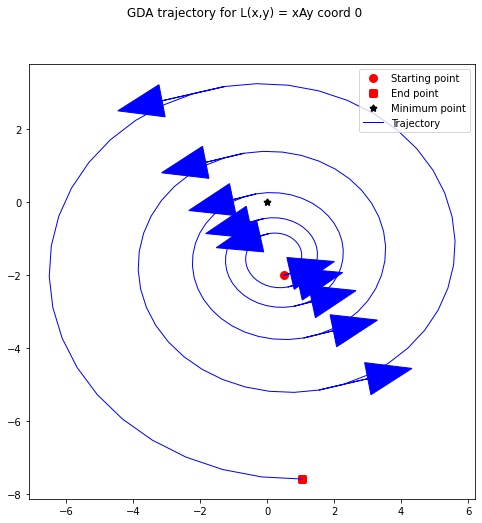

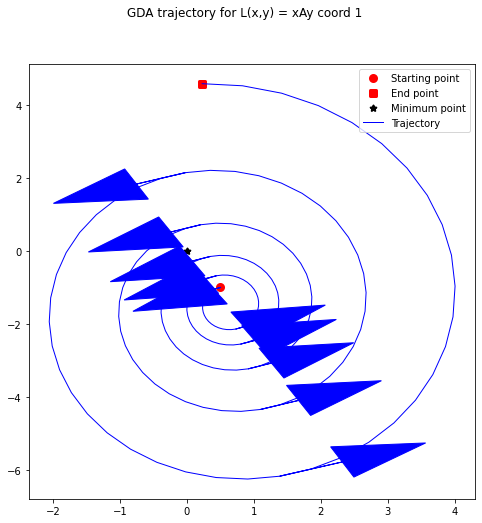

In [684]:
gamma = 0.1
max_iters = 200

points, update_directions = GDA(A, z0, gamma, max_iters)

## Extra Gradient Method 
$z' = z_t - sF(z_t), z_t = z - sF(z)$

In [685]:
def EGM(A, z0, gamma, max_iters, plot = True):
    """Extra Gradient Method"""
    points = []
    update_directions = []

    z = np.copy(z0)
    z_t = np.copy(z0)
    
    #timer = time.time()
    for n_iter in range(max_iters):
        points.append(np.copy(z))
        # Update intermediary point
        grad_z = F(A, z)
        z_t = z - gamma*grad_z

        # Update next point
        update_direction = -F(A, z_t)
        z += gamma*update_direction

        update_directions.append(np.copy(update_direction))
    print(points[len(points)-1]) 
    #print(timer)

    if plot:
        plot_trajectory(points, update_directions, max_iters, 'EGM trajectory for L(x,y) = xy', nb_arrows = 15, line_color='g', arrowhead=0.03)

    return points, update_directions

[[ 0.29871621  0.60064189]
 [-1.5004522  -1.4995478 ]]


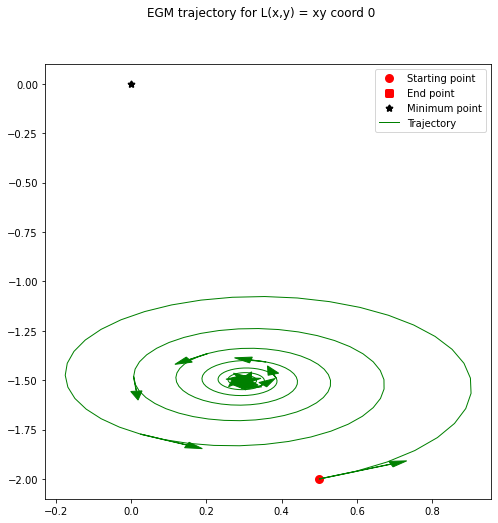

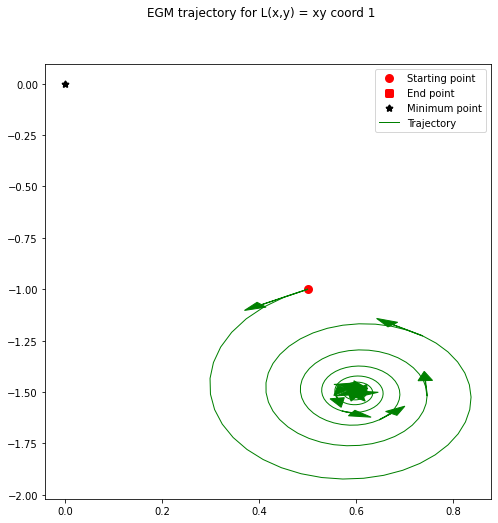

In [686]:
gamma = 0.1
max_iters = 500

points, update_directions = EGM(A, z0, gamma, max_iters)

## Optimistic Gradient Descent Ascent
$z'' = z' - 2sF(z') + sF(z)$

In [687]:
def OGDA(A, z0, gamma, max_iters, plot = True):
    """Optimistic Gradient Descent Ascent Method"""
    points = []
    update_directions = []

    z = np.copy(z0)
    
    # First iteration
    points.append(np.copy(z))
    # Compute update direction
    update_direction = -F(A, z)
    update_directions.append(np.copy(update_direction))

    # Update z with the algorithm
    z += gamma * update_direction

    # Rest of the iterations
    #timer = time.time()
    for n_iter in range(1,max_iters):
        points.append(np.copy(z))
        # Update next iterate point
        grad_z = F(A, z)
        grad_z_minus_1 = F(A, points[n_iter - 1])

        update_direction = -2 * grad_z + grad_z_minus_1
        update_directions.append(update_direction)

        z += gamma*update_direction
    print(points[len(points)-1])
    #print(timer)
    
    if plot:
        plot_trajectory(points, update_directions, max_iters, 'OGDA trajectory for L(x,y) = xy', nb_arrows = 15, line_color='orange')

    return points, update_directions

[[ 0.29907446  0.60046277]
 [-1.50037392 -1.49962608]]


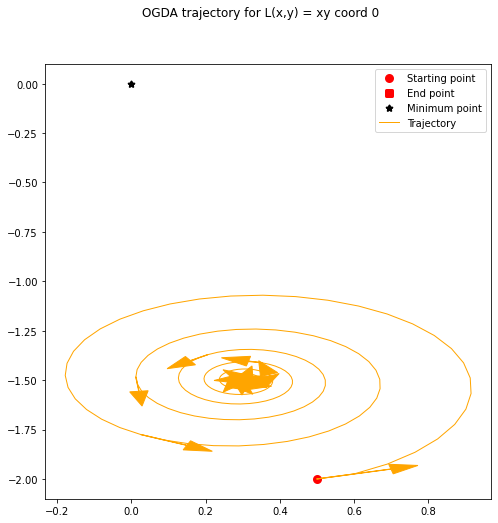

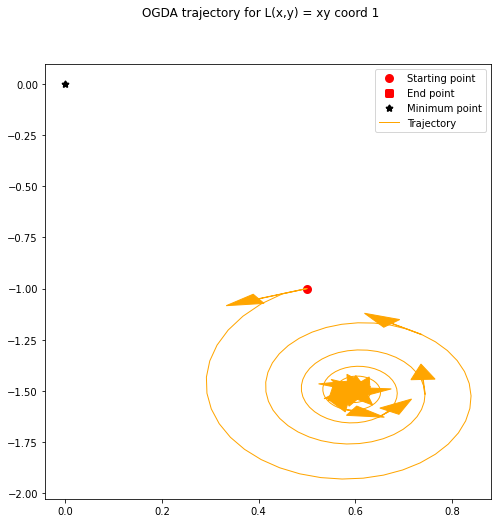

In [688]:
gamma = 0.1
max_iters = 500

points, update_directions = OGDA(A, z0, gamma, max_iters)

## Jacobian Method 
$z' = z + s\nabla F(z) F(z)$

In [689]:
def apply_Grad_F(A,grad_z):
    return np.array([A @ grad_z[1], -grad_z[0].T @ A])

In [690]:
def JM(A, z0, gamma, max_iters, plot = True):
    """Jacobian Method"""
    points = []
    update_directions = []

    z = np.copy(z0)
    
    #timer = time.time()
    for n_iter in range(max_iters):
        points.append(np.copy(z))
        # Update next iterate point
        grad_z = F(A, z)

        update_direction = apply_Grad_F(A, grad_z)

        update_directions.append(update_direction)

        z += gamma*update_direction
    print(points[len(points)-1])
    #print(timer)
    
    if plot:
        plot_trajectory(points, update_directions, max_iters, 'JM trajectory for L(x,y) = xy', nb_arrows = 5, line_color='yellow', arrowhead = 0.01)

    return points, update_directions

[[ 0.3  0.6]
 [-1.5 -1.5]]


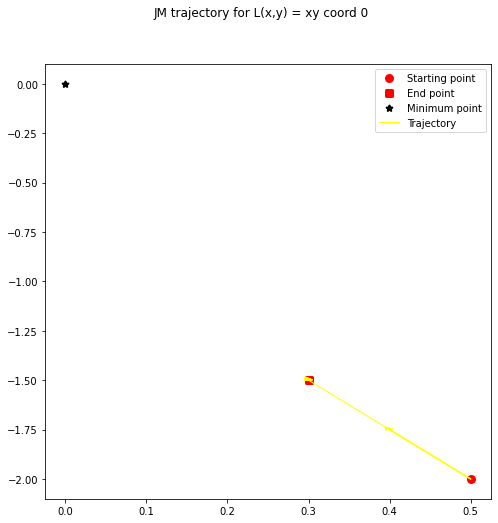

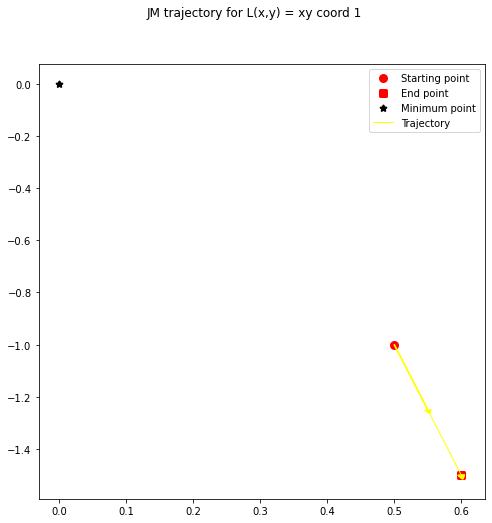

In [691]:
gamma = 0.1
max_iters = 500

points, update_directions = JM(A, z0, gamma, max_iters)

Compare all of them on the same plot

In [692]:
def compare_all_methods(A, z0, gamma, max_iters, legend=True):
    z_gda, updts_gda = GDA(A, z0, gamma, max_iters, False)
    z_egm, updts_egm = EGM(A, z0, gamma, max_iters, False)
    z_ogda, updts_ogda = OGDA(A, z0, gamma, max_iters, False)
    z_jm, updts_jm = JM(A, z0, gamma, max_iters, False)

    zs = [z_gda, z_egm, z_ogda, z_jm]
    colors = ['b', 'g', 'orange', 'yellow']
    titles = ['GDA', 'EGM', 'OGDA', 'JM']

    nb_coords = z_gda[0].shape[1]

    for n in range(nb_coords):
        plt.scatter(z0[0][n], z0[1][n], color = 'r', lw = 3, label = "Starting point")
        plt.scatter(0, 0, color = 'k', lw = 2, label = "Minimum point", marker='*')

        for i in range(len(zs)):
            xs = [z[0][n] for z in zs[i]]
            ys = [z[1][n] for z in zs[i]]
            plt.rcParams["figure.figsize"] = (8,8)
            plt.plot(xs, ys, color = colors[i], label = f'{titles[i]}')
        
        lim = 3
        plt.xlim(-lim,lim)
        plt.ylim(-lim,lim)
        if legend:
            plt.legend(loc = 'upper right')
            plt.suptitle(f'Trajectories of the 4 methods coord {n}')
        plt.show()

[[ 1.04709522  0.22645239]
 [-7.5905769   4.5905769 ]]
[[ 0.34400069  0.57799965]
 [-1.52856459 -1.47143541]]
[[ 0.34032597  0.57983702]
 [-1.52506422 -1.47493578]]
[[ 0.3  0.6]
 [-1.5 -1.5]]


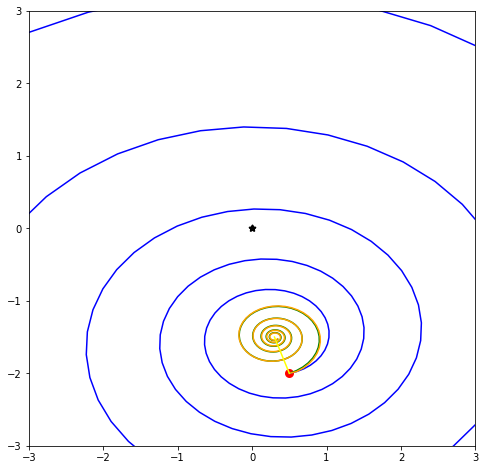

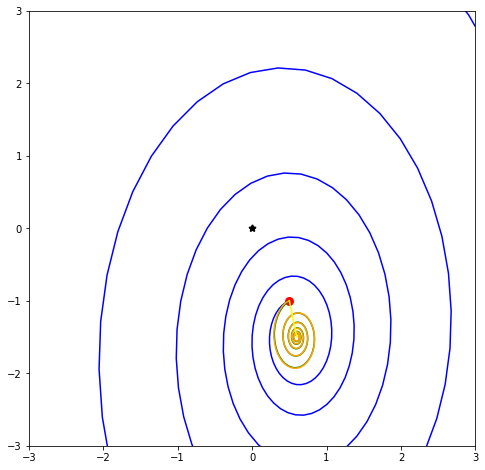

In [693]:
gamma = 0.1
max_iters = 200
compare_all_methods(A, z0, gamma, max_iters, legend=False)